### Project Report Group 12

Great project and a great proposal layout. I also appreciate ensuring the code is reproducible. Some feedback regarding the different components:

Throughout the project, make sure you back up any claims you make (ex. heart disease is the greatest killer in the world) using trusted sources.

When conducting your exploratory analysis, I recommend avoiding standardizing your variables. Scaling/centering is necessary when you're building a KNN model with multiple variables. For exploratory analysis, your data loses interpretability once you scale/center.

For your graphs, I suggest using boxplots to compare variables in a more obvious manner. While scatter plots are prettier to look at, they can sometimes be less informative/confusing to interpret. Reach out if you have any questions about building/reading boxplots (geom_boxplot). Besides that, I appreciate the visualizations you created. While the histograms are useful, I recommend setting position = "identity" and not faceting the plot (unless you're putting one over the other). This allows you to compare the peak/center between individuals with/without heart disease. 

Again, i recommend not scaling the data at this stage. Also, in your final report, please make sure you spend more time interpreting your graphs in commentary. For example: "The distribution of ages of individuals diagnosed with heart disease is shifted to the right relative to those with no heart disease (i.e. they're older). Based on this, I believe age is a good predictor for heart disease."

In your methods, make sure you address how you plan on defining the best value of K. Great job with the rest of the methods section.

# Title: Heart Disease Prediction

# Introduction:

**Background Information**
<br>
Heart diseases are a specific group of cardiovascular diseases that refer to conditions specifically affecting the behaviour or structure of the heart. These types of diseases are the leading cause of death across the world (Cardiovascular Diseases, 2019) which explains why diagnosis at an early stage is important so that patients can get immediate treatment. Multiple underlying health conditions and lifestyle choices can increase the likelihood of heart diseases, such as diabetes, and high blood pressure. Some possible symptoms of heart disease are heart attacks, and strokes.

**Our Question:**
<br>
How accurately can we identify whether or not a patient has heart disease based on their age, resting blood pressure, and cholesterol level?

This dataset is a combination of 5 smaller datasets including the Cleveland, Hungarian, Switzerland, Stalog (Heart) Data Set, and Long Beach VA datasets all originally sourced from the UCI Machine Learning Repository. It contains information on health factors of patients and whether or not these patients had heart disease.

# Methods & Results:

### Import necessary libraries

In [1]:
# import needed libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Load data from source on the web 

Kaggle page for dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [2]:
# read dataset from web
heart <- read_csv("https://raw.githubusercontent.com/josephsoo/dsci_100_group_12/main/data/heart.csv")


Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Wrangle and clean the data

Below we wrangle and clean the data by turning the HeartDisease column into a factor type and removing the rows
where cholesterol = 0.

Note: HeartDisease = 0 means the person *does not* have heart disease. HeartDisease = 1 means the person *does* have it.

In [3]:
# clean and wrangle into tidy format
# by turning HeartDisease in a factor type and 
# removing rows where cholesterol = 0
heart_clean <- mutate(heart, HeartDisease = as_factor(HeartDisease)) |> filter(Cholesterol != 0)
head(heart_clean)


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


We will be using 3 predictors: Cholesterol, Resting BP (blood pressure), and Age. Therefore, we will only select the releveant columns. More reasons as to why we chose these 3 can be found later on in the report.

In [8]:
heart_clean <- select(heart_clean, Age, RestingBP, Cholesterol, HeartDisease)
head(heart_clean)

Age,RestingBP,Cholesterol,HeartDisease
<dbl>,<dbl>,<dbl>,<fct>
40,140,289,0
49,160,180,1
37,130,283,0
48,138,214,1
54,150,195,0
39,120,339,0


#### Split the data

We will now split the data into training and testing sets. 75% of the data will be used for training and 25% will be used for testing.

We have also set the seed to allow for reproducible results.

In [9]:
set.seed(3456) 

# splitting data 75% = training, 25% = testing
heart_split <- initial_split(heart_clean, prop = 0.75, strata = HeartDisease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

### Creating tables to summarize the training data

We have made tables showing the number of observations in each class and showing the mean of each predictor to analyze/summarize the data.

In [ ]:
# number of observations in each class of heart disease
heart_disease_count <- heart_train |> group_by(HeartDisease) |> summarize(n = n())
heart_disease_count

# averages of each predictor variable
predictor_means <- heart_train |> select(-HeartDisease) |> map_df(mean)
colnames(predictor_means) <- c("Age_mean", "RestingBP_mean", "Cholesterol_mean")
predictor_means

HeartDisease,n
<fct>,<int>
0,292
1,267


Age_mean,RestingBP_mean,Cholesterol_mean
<dbl>,<dbl>,<dbl>
53.23077,133.5063,244.6869


We can see that the split between people with and without heart disease is generally pretty even (52% of data is people without, and 48% is people with). 

**something talking about the means?**

## Creating data visualizations of the training data



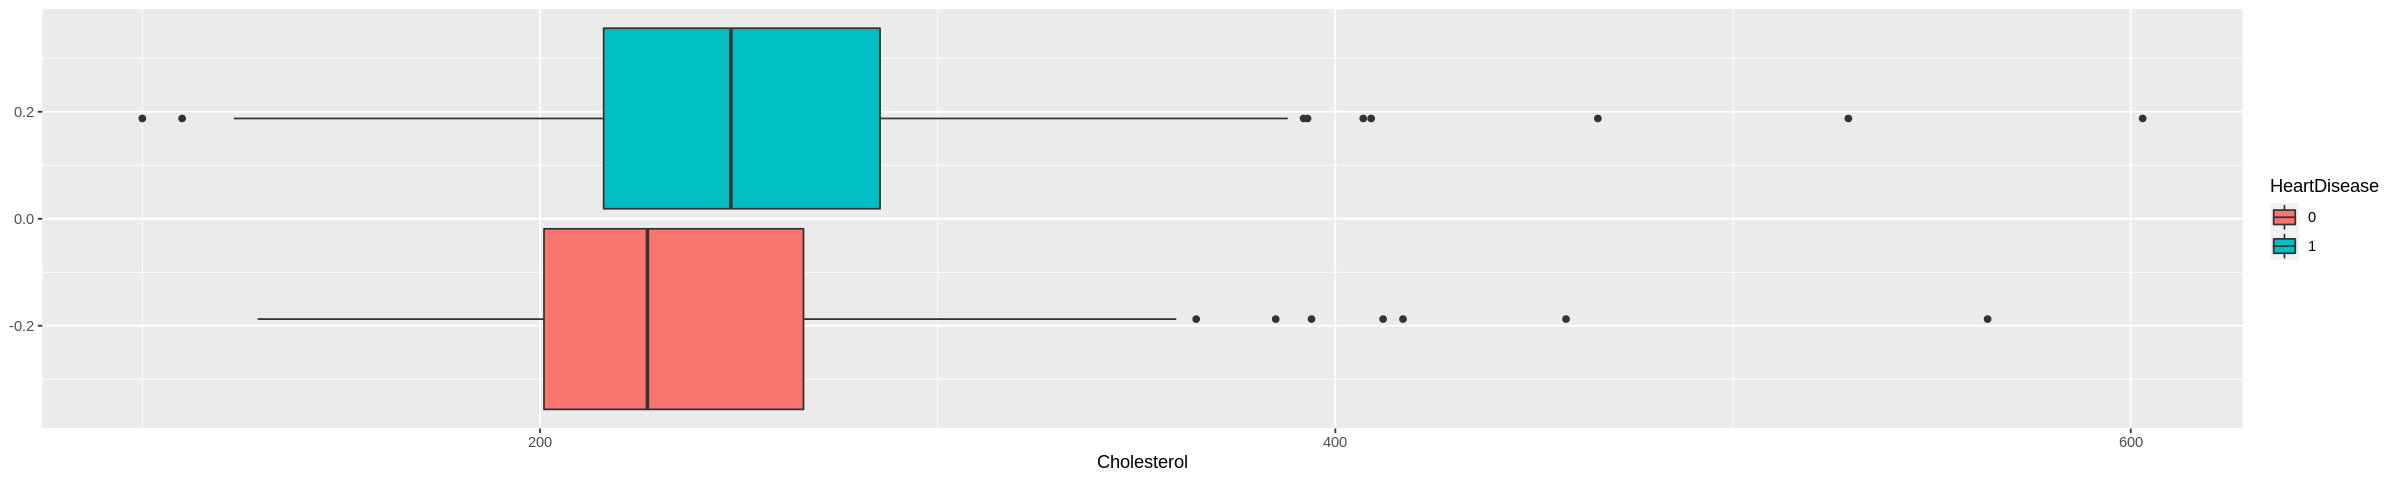

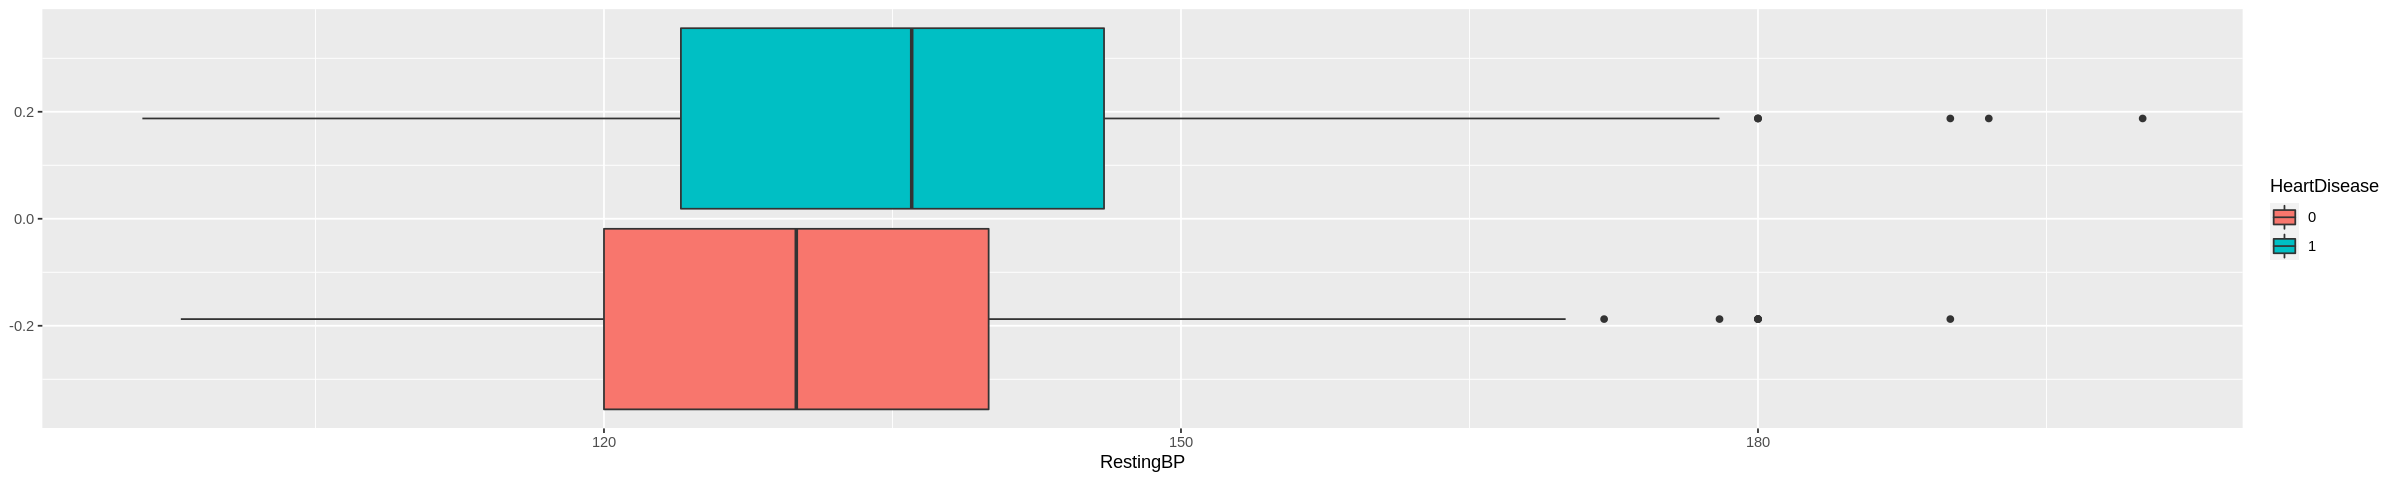

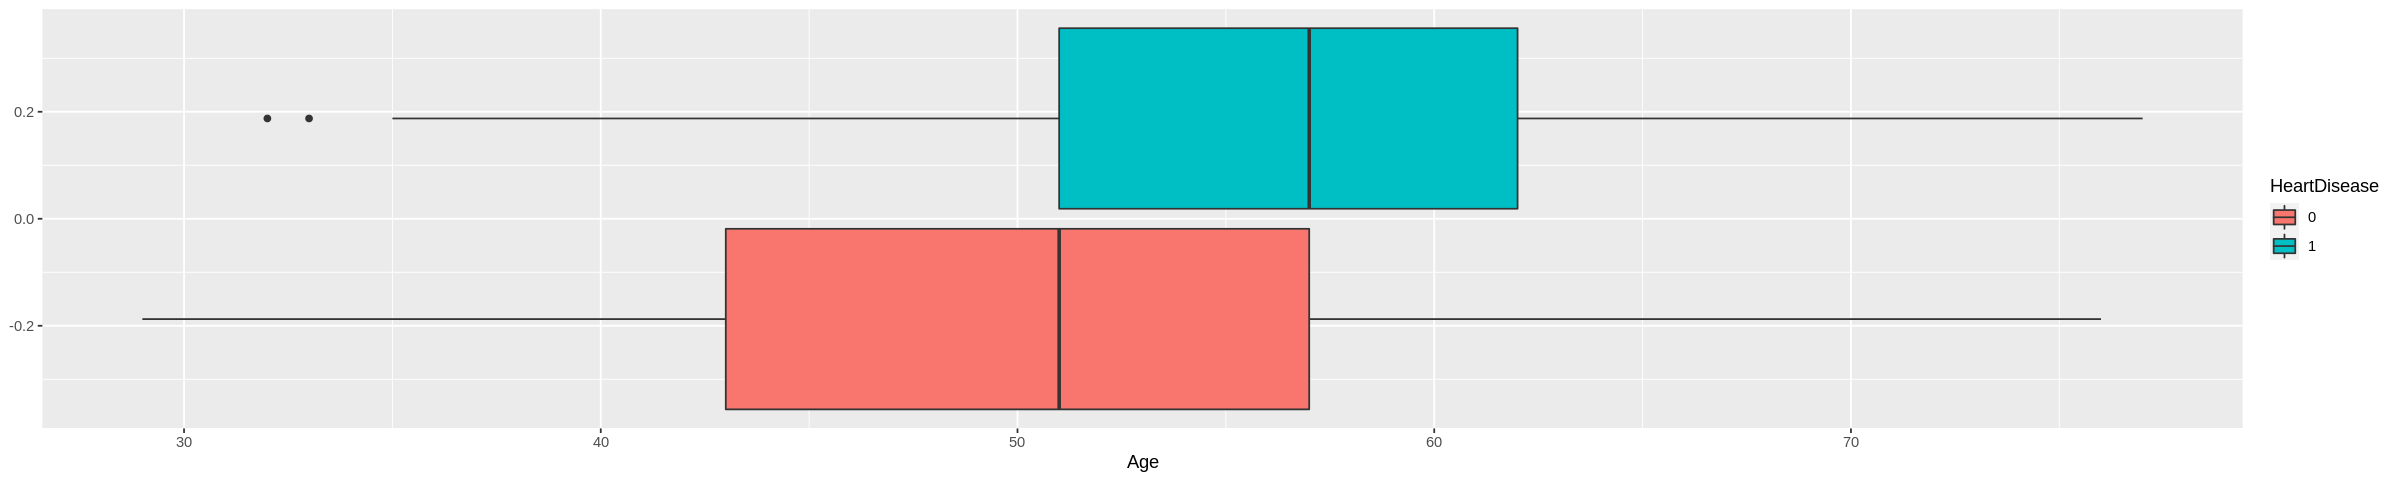

In [12]:
options(repr.plot.width = 20, repr.plot.height = 4)

cholesterol_histo <- heart_train |> ggplot(aes(x = Cholesterol, fill = HeartDisease)) +
    geom_boxplot()


bp_histo <- heart_train |> ggplot(aes(x = RestingBP, fill = HeartDisease)) +
    geom_boxplot() 

age_histo <- heart_train |> ggplot(aes(x = Age, fill = HeartDisease)) +
    geom_boxplot()


cholesterol_histo
bp_histo
age_histo


## Discussion:

## References

Cardiovascular diseases. (2019, June 11). World Health Organization. https://www.who.int/health-topics/cardiovascular-diseases